In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ..
%pwd

/home/markus/Documents/regression-prediction


'/home/markus/Documents/regression-prediction'

In [3]:
from experiments.data_utils import *
from experiments.plot_utils import *

In [4]:
X, y, features = get_ml_data_traditional('bugbug', 'performance', 'commitlevel')

performance: 4062 positive 4.07% - negative 95632 95.93%
X.shape=(99694, 301)



In [5]:
features

,lines_added,lines_deleted,lines_modified,number_of_modified_files,number_of_subsystems,number_of_directories,entropy_lines_modified,comment_length,developer_age,developer_experience,...,min_delta_loc_lloc,min_delta_loc_cloc,min_delta_loc_blank,min_delta_nom_functions,min_delta_nom_closures,min_delta_nom_total,min_delta_mi_mi_original,min_delta_mi_mi_sei,min_delta_mi_mi_visual_studio,target
revision,,,,,,,,,,,,,,,,,,,,,
1582b3ffe71226af68979a58b5852afa49ff939b,55,13,68,0,2,2,1.422138,21,378751,832,...,2.0,0.0,1.0,0.0,0.0,0.0,-0.589408,-0.706975,0.000000,0
199bcb54e5122b5e7ac2476c90288b2169db2013,0,0,0,0,0,0,0.000000,12,114075,690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7d964bfcda0e0aded01a4fb05a8405b9cb61bafd,15,2,17,0,1,1,0.522559,11,114076,691,...,2.0,0.0,0.0,0.0,0.0,0.0,-3.968025,-7.528525,-2.320483,0
696aa5fa31ea5c39cee412a6cecfd4af19f845fd,8,6,14,0,1,2,0.749595,12,114077,692,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.172779,-0.330138,-0.101040,0
da65877c0fec3c21af44c542bada87ea8e8c6eea,13,9,22,0,1,1,0.000000,21,439301,2415,...,2.0,0.0,0.0,0.0,0.0,0.0,-0.025310,-0.052102,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2e03fdd340bda8085be8e6dc6e5277f09aa8a171,11,0,11,0,1,1,0.000000,55,110869,295,...,2.0,6.0,2.0,0.0,0.0,0.0,-0.627029,-0.335385,-0.366684,0
f398c3d4e21385a4b57ff67609fecca718a21416,1,1,2,0,1,1,0.000000,53,515072,1372,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.000616,-0.000889,0.000000,0
6e81bb1b5c7b19bff22b847d72d814cb1c7a63fa,0,0,0,0,0,0,0.000000,13,284398,206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [6]:
feature_names = features.columns
feature_names

Index(['lines_added', 'lines_deleted', 'lines_modified',
       'number_of_modified_files', 'number_of_subsystems',
       'number_of_directories', 'entropy_lines_modified', 'comment_length',
       'developer_age', 'developer_experience',
       ...
       'min_delta_loc_lloc', 'min_delta_loc_cloc', 'min_delta_loc_blank',
       'min_delta_nom_functions', 'min_delta_nom_closures',
       'min_delta_nom_total', 'min_delta_mi_mi_original',
       'min_delta_mi_mi_sei', 'min_delta_mi_mi_visual_studio', 'target'],
      dtype='object', length=302)

In [7]:
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import sklearn.metrics as metrics

/home/markus/Documents/regression-prediction/venv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
shap.initjs()

In [9]:
def plot_important_features(clf, X, feature_names):
    explainer = shap.TreeExplainer(clf)
    #explainer = shap.Explainer(clf)

    # print(explainer)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, max_display=10, feature_names=feature_names)
    plt.show()

In [10]:
def ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf):
    clf.fit(X_train, y_train)

    print("Train:")
    y_pred = clf.predict(X_train)
    report = metrics.classification_report(y_train, y_pred)
    print(report)
    plot_important_features(clf, X_train, feature_names)
    #ConfusionMatrixDisplay(confusion_matrix(y_train, y_pred), display_labels=['no regr.', 'regr.']).plot()
    plt.show()

    print("Test:")
    y_pred = clf.predict(X_test)
    report = metrics.classification_report(y_test, y_pred)
    print(report)
    #plot_important_features(clf, X_test, feature_names)
    plot_precision_recall_curve_with_f1(clf, X_test, y_test)

    #ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=['no regr.', 'regr.']).plot()
    #plt.show()

In [11]:
def make_clf():
    clf = xgboost.XGBClassifier(
        n_jobs=4,
        use_label_encoder=False,
        eval_metric='logloss'
        )
    return clf

# def make_clf():
#     from sklearn.linear_model import LogisticRegression
#     clf = LogisticRegression()
#     return clf

Train:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     86100
           1       1.00      0.66      0.80      3624

    accuracy                           0.99     89724
   macro avg       0.99      0.83      0.90     89724
weighted avg       0.99      0.99      0.99     89724



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


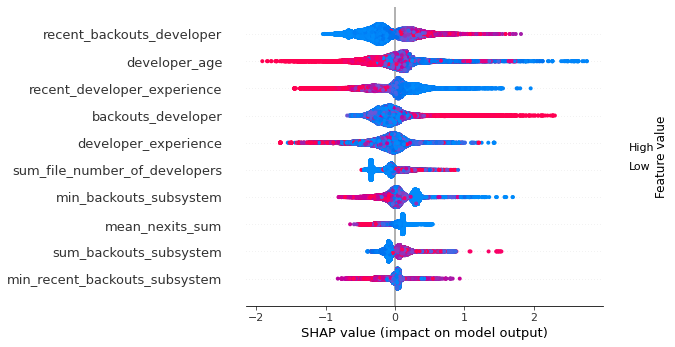

Test:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      9532
           1       0.94      0.38      0.54       438

    accuracy                           0.97      9970
   macro avg       0.96      0.69      0.77      9970
weighted avg       0.97      0.97      0.97      9970

best F1: 0.6666666666666666 at precision=0.7678571428571429 recall=0.589041095890411


invalid value encountered in true_divide


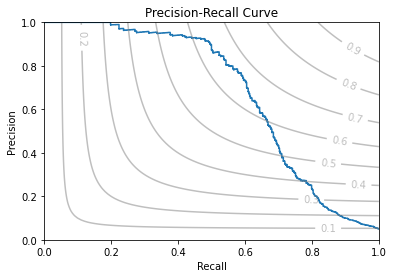

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = make_clf()
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)
clf = make_clf()    
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

## Why?

In [ ]:
labeling = pd.read_csv('data/labeling/bugbug.csv')
labeling['index'] = labeling['revision']
labeling.set_index('index', inplace=True)
labeling

In [ ]:
bug_ids = set(labeling['bug_id'])

In [ ]:
bug_id_counts = (labeling
    .loc[labeling['performance']==1, ['revision', 'bug_id']]
    .groupby('bug_id').count()
    .sort_values('revision'))

bug_id_counts.value_counts().sort_index()

### How many performance bug have single commit vs multiple commits?

In [ ]:
single_commit_bug_ids = set(bug_id_counts[bug_id_counts['revision'] == 1].index)
multi_commit_bug_ids = set(bug_id_counts[bug_id_counts['revision'] > 1].index)

total = len(single_commit_bug_ids) + len(multi_commit_bug_ids)
print(f"#single = {len(single_commit_bug_ids)}, #multiple = {len(multi_commit_bug_ids)}, total = {total}")

### And how many commits ?

In [ ]:
single_commit_bug_commits = labeling.loc[labeling['bug_id'].isin(single_commit_bug_ids), 'revision']
multi_commit_bug_commits = labeling.loc[labeling['bug_id'].isin(multi_commit_bug_ids), 'revision']

total = len(single_commit_bug_commits) + len(multi_commit_bug_commits)
print(f"#single = {len(single_commit_bug_commits)}, #multiple = {len(multi_commit_bug_commits)}, total = {total}")

In [ ]:
from src.repo_miner import get_commit_log
commit_log = get_commit_log('data/repo_miner/commit_log.csv')
commits = commit_log.drop('revision', axis=1).join(labeling, how='inner')
commits

In [ ]:
bug_id = 1700052
commits[commits['bug_id'] == bug_id]

In [ ]:
df = features.loc[
    commits['bug_id'] == bug_id,
    [
        'developer_age',
        'recent_developer_experience',
        'recent_backouts_developer'
    ]
].iloc[:5]
df.index.name = 'revision hash'
df

### Does XGBoost learn proxy for revision id?

### Does it just memorize the position of the labels?

In [ ]:
# only take id
y = np.array(commits['performance'], 'int')

X = commits[['id']]

feature_names = X.columns
X = np.array(X)
print(f'{X.shape=}\n')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = make_clf()  
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)
clf = make_clf()
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [ ]:
import matplotlib.pyplot as plt

labeling = pd.read_csv('data/labeling/bugbug.csv')
labeling.set_index('revision', inplace=True)

for kind in ['commitlevel', 'buglevel']:
    target = 'performance'

    features = pd.read_csv(f'data/feature_extractor/features_{kind}.csv')

    if kind == 'buglevel':
        # labeling is based on bugnumber, that's why it is ok to index at
        # first revision of a commit group in case of kind=='buglevel'
        features['revision'] = features['first_revision']
        features['id'] = features['first_id']

    features.set_index('revision', inplace=True)


    features['target'] = labeling[target] # works because index is revision hash

    subset = features[(483000 <= features['id']) & (features['id'] <= 485000)]

    plt.figure(figsize=(24, 4))
    plt.scatter(
        subset.loc[subset['target'] == 1, 'id'], 
        np.full((subset['target'] == 1).sum(), 1),
        s=1)
    plt.title(kind)
    plt.show()

## Now compare to buglevel

In [ ]:
X, y, features = get_ml_data_traditional('bugbug', 'performance', 'buglevel')
feature_names = features.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
clf = make_clf()       
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=False)
clf = make_clf()       
ml_pipeline(X_train, X_test, y_train, y_test, feature_names, clf)